# Modelo de recomendação de Filmes
Este caderno contém a criação do modelo usado para recomendar filmes que estão ou vão entrar em cartaz no cinema.
Dados utilizados:https://grouplens.org/datasets/movielens/

#### Solução:
     A solução encontrada pela equipe consiste na utilização de um chatbot com a principal funcionalidade de compras de ingresso para o cinema. Além disso, o chatbot contará com uma ferramenta de recomendação de filmes que estão em cartaz ou que chegarão em breve. 
        Esse notebook contém a aplicação de um modelo de Machine Learning utilizando um algorítmo de clusterização (KMeans) para identificar grupos que possam ter gostos similares para filmes. A partir desse modelo, foi feito um algorítmo para encontrar filmes que outros usuários do mesmo grupo (cluster) também gostaram. 
        
        Essa implementação é a POC do Status 2.

#### Perguntas levantadas para construção da solução
    1. Como fazer com que estes dados representem o gosto do usuário?
    2. Como gerar uma forma de classificar os clientes pelos seus padrões de consumo?
    3. A partir desse padrão, como recomendar um filme que ele goste?
    4. Como recomendar filmes que estão e vão entrar em cartaz para clientes que tem mais chance de gostar?


In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
from plotly.offline import iplot
from scipy import stats
from sklearn.cluster import KMeans,MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, MinMaxScaler

#### Como fazer com que estes dados representem o gosto do usuário?
        Cada linha do dataset* contém uma review feita pelo usuário. A partir dessa linha foi gerada outra coluna contendo a média de nota o usuário deu para todos os filmes, ou seja, cada usuário tem uma média de notas diferente. A outra coluna gerada foi a adg_rating que representa a diferença de nota entre a média de notas que o usuário deu e a nota que ele deu para o filme que ele fez a review.   
        Utilizando apenas as colunas userId, movieId e adg_rating, foi criado um novo dataset que contem o userId como linhas, movieId como colunas e o valor sendo o adg_rating. A razão disso seria porque os valores negativos representariam que o usuário não gostou do filme e os positivos que o usuário gostou. Para os valors NaN, foi colocado a média de adg_rating do movieId.
    
        *Num ambiente com mais recursos o modelo deveria utilizar todos os dados, porém, como essa base de dados possui um tamanho muito grande, foi utilizado apenas os primeios 250.000 valores.

In [2]:
movies = pd.read_csv("movies.csv",encoding="Latin1")
Ratings = pd.read_csv("ratings.csv")
Mean = Ratings.groupby(by="userId",as_index=False)['rating'].mean()
Rating_avg = pd.merge(Ratings,Mean,on='userId')
Rating_avg['adg_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
Rating_avg.head()

,userId,movieId,rating_x,timestamp,rating_y,adg_rating
0,1,296,5.0,1147880044,3.814286,1.185714
1,1,306,3.5,1147868817,3.814286,-0.314286
2,1,307,5.0,1147868828,3.814286,1.185714
3,1,665,5.0,1147878820,3.814286,1.185714
4,1,899,3.5,1147868510,3.814286,-0.314286


In [3]:
Rating_avg['movieId'].value_counts().describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: movieId, dtype: float64

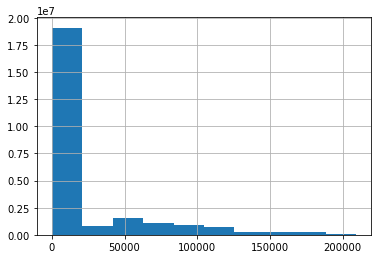

In [4]:
Rating_avg['movieId'].hist()

In [5]:
n = int(len(Rating_avg['movieId'].value_counts())/50)
list_top_25 = Rating_avg['movieId'].value_counts()[:n].index.tolist()
len(list_top_25)

1180

In [6]:
sample = Rating_avg[Rating_avg['movieId'].isin(list_top_25)]

In [7]:
final=pd.pivot_table(sample, values='adg_rating', index='userId', columns='movieId')
final

movieId,1,2,3,5,6,7,10,11,14,16,...,128360,134130,134853,139385,142488,148626,152081,164179,166528,168252
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.130435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.302591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.302591,0.302591,0.302591,NaN,0.302591,NaN,0.302591,0.302591,0.302591
4,-0.378099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.621901,NaN,1.621901,NaN,0.621901,1.121901,1.621901,0.621901,NaN
5,0.247525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162538,-1.415584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
final_movie = final.fillna(final.mean(axis=0))
final_movie

movieId,1,2,3,5,6,7,10,11,14,16,...,128360,134130,134853,139385,142488,148626,152081,164179,166528,168252
userId,,,,,,,,,,,,,,,,,,,,,
1,0.260465,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.259378,0.194525,0.136508,0.397494,0.319092,0.172771,0.296863,0.097342,0.158714
2,-0.130435,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.259378,0.194525,0.136508,0.397494,0.319092,0.172771,0.296863,0.097342,0.158714
3,0.302591,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.302591,0.302591,0.302591,0.397494,0.302591,0.172771,0.302591,0.302591,0.302591
4,-0.378099,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.621901,0.194525,1.621901,0.397494,0.621901,1.121901,1.621901,0.621901,0.158714
5,0.247525,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.259378,0.194525,0.136508,0.397494,0.319092,0.172771,0.296863,0.097342,0.158714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,0.260465,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.259378,0.194525,0.136508,0.397494,0.319092,0.172771,0.296863,0.097342,0.158714
162538,-1.415584,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.259378,0.194525,0.136508,0.397494,0.319092,0.172771,0.296863,0.097342,0.158714
162539,0.260465,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,-0.062597,0.280523,...,0.227482,0.259378,0.194525,0.136508,0.397494,0.319092,0.172771,0.296863,0.097342,0.158714


#### Criação do Modelo
        Como dito anteriormente foi escolhido clusterização como abordagem para a solução ultilizando, a princípio, o KMeans. Nesse modelo, primeiramente é escolhido o número de clusters que será dividido os usuários e, a partir dele, será gerado um modelo para identificar esses grupos.  
        Para escolher o número de clusters, foi utilizado o Método do Cotovelo. Esse método serve para encontrar o número ótimo de clusters*. 
        *Para esse dataset (por precisar de mais recursos que disponíveis), não será possivel gerar um número muito alto de clusters para utilizar esse método

--------------

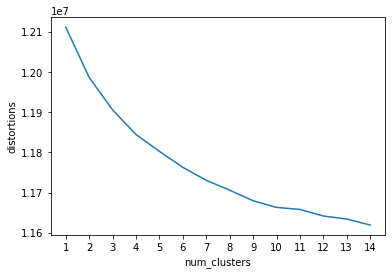

In [9]:
distortions = []
num_clusters =  range(1,15)


for n in num_clusters:
    print("-", end = '')
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(final_movie)
    distortions.append(kmeans.inertia_)
    
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(final_movie)
cluster_pred = kmeans.predict(final_movie)
cluster_pred

array([6, 4, 3, ..., 9, 6, 3])

In [17]:
unique_counts = collections.Counter(e for e in cluster_pred)
unique_counts

Counter({6: 88803,
         4: 4881,
         3: 6869,
         9: 28717,
         2: 11376,
         5: 1342,
         0: 5701,
         8: 7789,
         7: 5317,
         1: 1724})

#### Visualização do Modelo
        Como esse modelo possue muitas colunas fica difícil a visualização, desta forma foi utilizado um modelo Principal Component Análises para diminuir o dataset para apenas 2 colunas. 

In [18]:
x = final_movie.values
pca = PCA(n_components= 2, random_state=0)
pca.fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA1','PCA2'])
principalDf

,PCA1,PCA2
0,-0.051934,0.448595
1,1.850229,-0.354391
2,0.601089,1.110792
3,0.321399,1.268291
4,0.735960,-0.134336
...,...,...
162514,0.548929,-0.495483
162515,-0.913498,-0.381552
162516,-0.606466,-0.150300
162517,0.594976,-0.485609


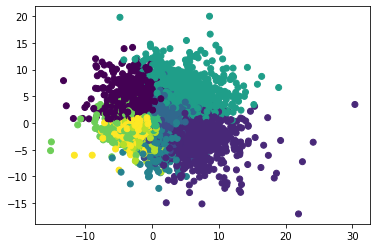

In [19]:
plt.scatter(principalDf['PCA1'], principalDf['PCA2'], c=cluster_pred)